# Hands-On NLP Workshop: *Detecting Sentiment Using Tweets to US Airlines*

Within this hands-on workshop you will analyse tweets from customers of airlines about their performance. These were scraped from Twitter in 2015, and will be categorised in positive, neutral or negative sentiment. 
  
The steps which have been carried out
1. Load The Data 
2. Data Visualization 
3. Text Preprocessing and Cleaning  
4. Handling Imbalance         
5. Model Building  

The code in this notebook has been adapted from the brilliant work done by [Meisam Raz](https://www.kaggle.com/meisamraz/sentiment-analysis-96-acc-eda-text-preprocessing/notebook). 

In [1]:
# Colab has a load of packages pre-loaded into the environment. Installing the additional ones we require here.
!pip install seldon-deploy-sdk==1.4.1
!pip install alibi-detect==0.6.2
!pip install alibi==0.6.2
!pip install wordcloud
!pip install seaborn
!pip install dill
!pip install imblearn
!pip install nltk

  Using cached alibi_detect-0.6.2-py3-none-any.whl (150 kB)
     |████████████████████████████████| 7.2 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 174.3 MB 3.3 MB/s eta 0:00:01    |███████████████                 | 81.2 MB 3.2 MB/s eta 0:00:29     |████████████████████▋           | 112.4 MB 6.7 MB/s eta 0:00:10     |██████████████████████████▍     | 143.7 MB 3.7 MB/s eta 0:00:09
     |████████████████████████████████| 3.3 MB 23.6 MB/s eta 0:00:01
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
     |████████████████████████████████| 3.0 MB 3.7 MB/s eta 0:00:01
  Using cached wrapt-1.12.1.tar.gz (27 kB)
     |████████████████████████████████| 15.6 MB 3.8 MB/s eta 0:00:01
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached flatbuffers-1.12-py2.py3-non

In [2]:
# Basic Operation
import pandas as pd
import numpy as np

# Text Preprocessing & Cleaning
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import re
from sklearn.model_selection import train_test_split # Split Data 
from imblearn.over_sampling import SMOTE # Handling Imbalanced

# Model Building
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score # Performance Metrics  

# Drift Detection
from alibi_detect.cd import KSDrift
from alibi_detect.utils.saving import save_detector, load_detector

# Explainabilty
from alibi.explainers import AnchorText
import spacy
from alibi.utils.download import spacy_model

# Data Visualization 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from termcolor import cprint
import seaborn as sns
import warnings   

# Serialising artefacts
import joblib
import dill

# Deploy SDK 
from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, OutlierDetectorApi, DriftDetectorApi
from seldon_deploy_sdk.auth import OIDCAuthenticator

warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/josh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!wget https://storage.googleapis.com/seldon-koz-data/airline/airline.zip
!unzip -o 'airline.zip'

--2022-04-20 06:43:58--  https://storage.googleapis.com/seldon-koz-data/airline/airline.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.40.176, 142.250.80.112, 142.250.65.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.40.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734410 (2.6M) [application/zip]
Saving to: ‘airline.zip’

airline.zip         100%[===================>]   2.61M  3.37MB/s    in 0.8s    

2022-04-20 06:43:59 (3.37 MB/s) - ‘airline.zip’ saved [2734410/2734410]

Archive:  airline.zip
   creating: data/
  inflating: data/database.sqlite    
   creating: data/nltk_data/
   creating: data/nltk_data/corpora/
 extracting: data/nltk_data/corpora/stopwords.zip  
   creating: data/nltk_data/corpora/stopwords/
  inflating: data/nltk_data/corpora/stopwords/german  
  inflating: data/nltk_data/corpora/stopwords/romanian  
  inflating: data/nltk_data/corpora/stopwords/nepali  
  inflating: data/nl

## Data Exploration

Load the data into memory. 

In [4]:
df = pd.read_csv('./data/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Inspecting the columns within the data...

In [5]:
list(df.columns)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [6]:
df.shape

(14640, 15)

The dataset is 14,460 separate tweets to various US airlines which have been labelled according to their percevied sentiment. There is additional metadata associated with each tweet such as a location of where the tweet was created, the retweet count and the user name of the tweeter. 

Next we can begin to explore and visualise the data!

Number of tweets in each category:
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


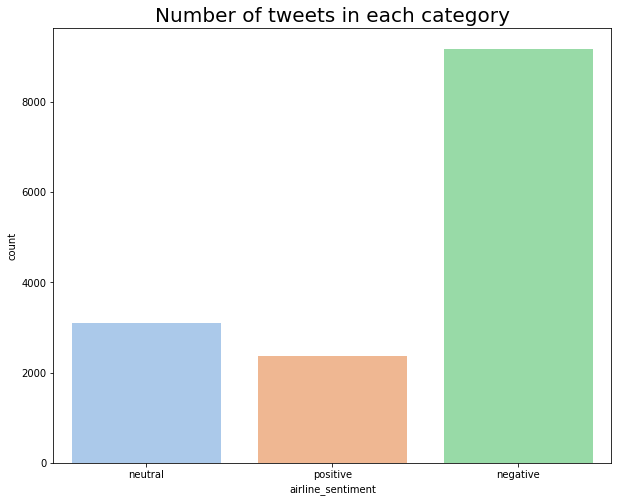

In [7]:
cprint("Number of tweets in each category:",'green')
print(df["airline_sentiment"].value_counts())

plt.figure(figsize=(10, 8))
ax = sns.countplot(x='airline_sentiment', data=df, palette='pastel')
ax.set_title(label='Number of tweets in each category', fontsize=20)
plt.show()

Who would have thought? People turn to Twitter when they're annoyed. 

Total number of tweets for each airline:
airline
American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: airline_sentiment, dtype: int64


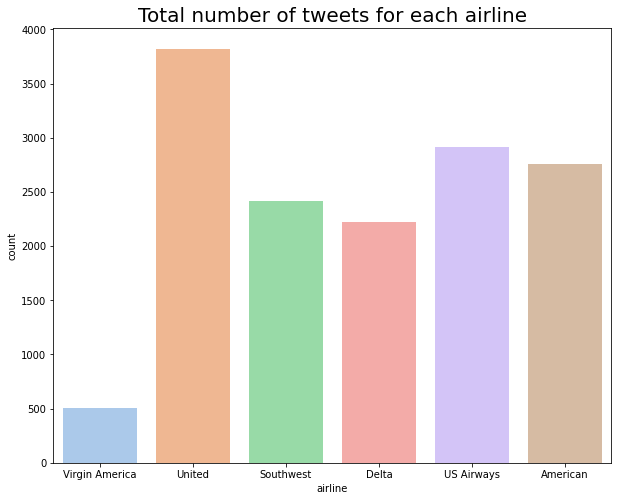

In [8]:
cprint("Total number of tweets for each airline:",'green')
print(df.groupby('airline')['airline_sentiment'].count())

plt.figure(figsize=(10, 8))
ax = sns.countplot(x='airline', data=df, palette='pastel')
ax.set_title(label='Total number of tweets for each airline', fontsize=20)
plt.show()

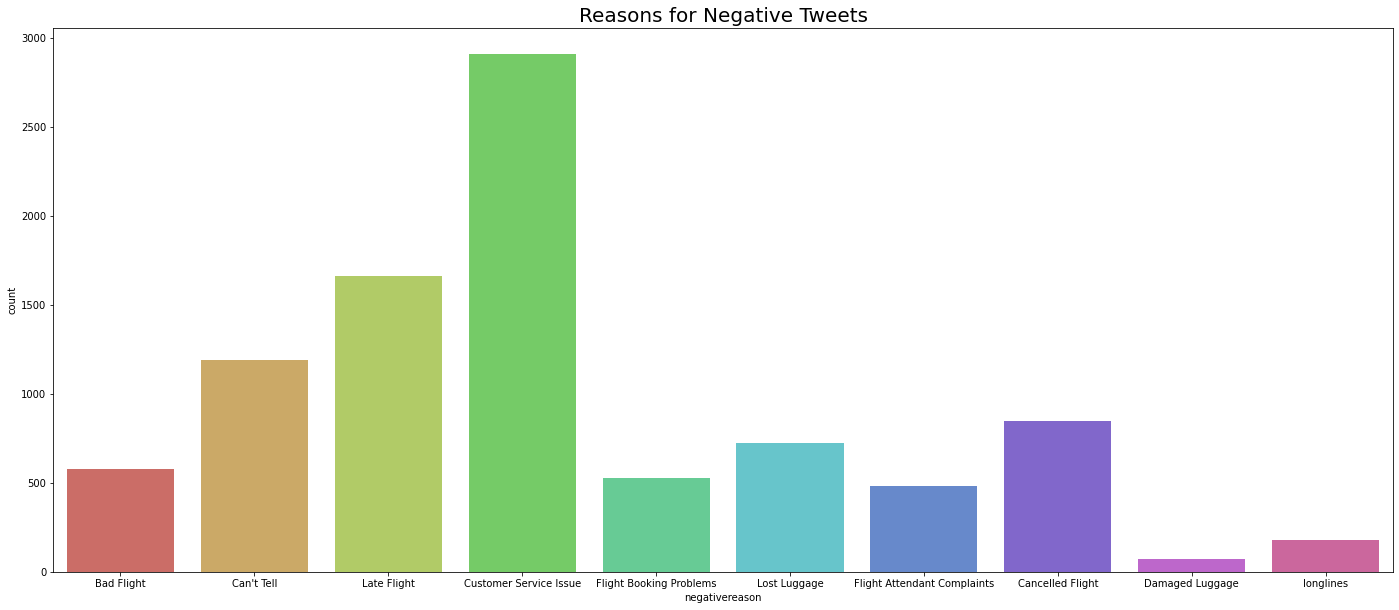

In [9]:
plt.figure(figsize=(24, 10))
sns.countplot(x='negativereason', data=df, palette='hls')
plt.title('Reasons for Negative Tweets', fontsize=20)
plt.show()

So at first glance it appears that customer service issues are the main driver of negatively sentimented tweets!

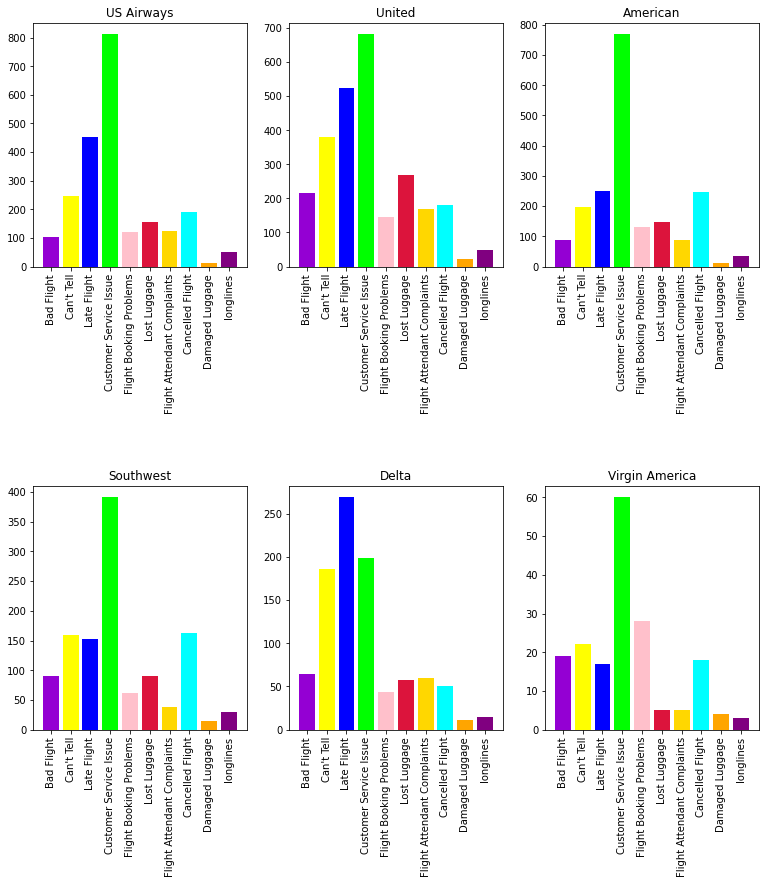

In [10]:
NR_Count=df['negativereason'].value_counts()
def NCount(Airline):
    airlineName =df[df['airline']==Airline]
    count= airlineName['negativereason'].value_counts()
    Unique_reason= df['negativereason'].unique()
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

def plot_reason(airline):
    a= NCount(airline)
    count=a['count']
    Id = range(1,(len(a)+1))
    plt.bar(Id,count, color=['darkviolet','yellow','blue','lime','pink','crimson','gold','cyan','orange','purple'])
    plt.xticks(Id,a['Reasons'],rotation=90)
    plt.title(airline)

airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
    
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

Breaking that down by airline, we can see that Delta is the only airline whose most frequent issue is late flights. All of the other providers suffer from customer service issues as their leading cause of negative tweets. 

Finally, we can generate word clouds to observe the most common words within each sentiment category. 

In [11]:
# Split text of Sentiments    
positive = df[df['airline_sentiment'] == 'positive'].text
neutral = df[df['airline_sentiment'] == 'neutral'].text
negative = df[df['airline_sentiment'] == 'negative'].text

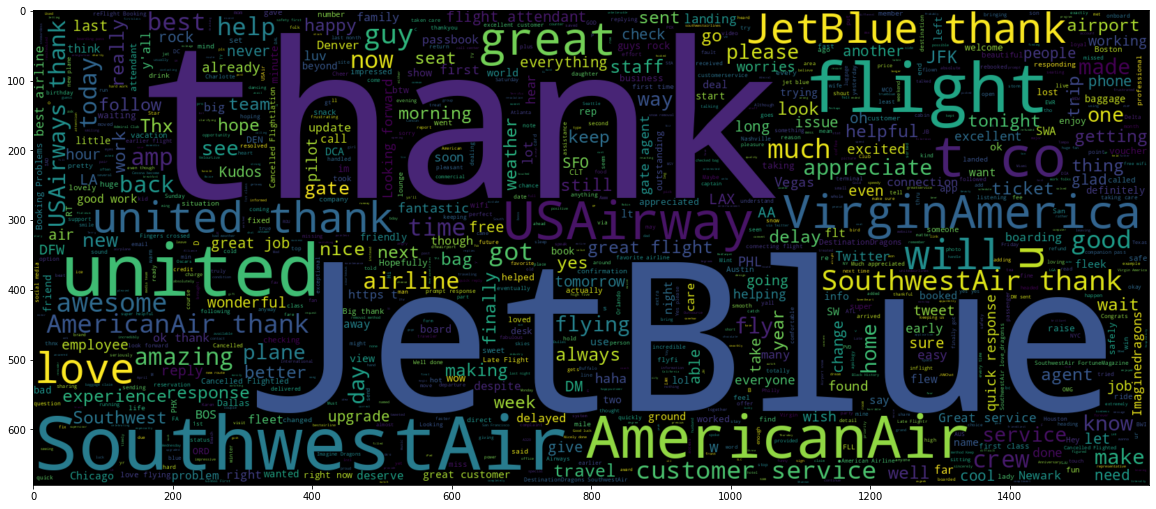

In [12]:
# word cloud of positive sentiments
plt.figure(figsize = (20,20)) 
worldcould_pos = WordCloud(min_font_size=3,
                           max_words=1000, 
                           width=1600,
                           height=680).generate(" ".join(positive))

plt.imshow(worldcould_pos,interpolation='bilinear')
ax.grid(False)

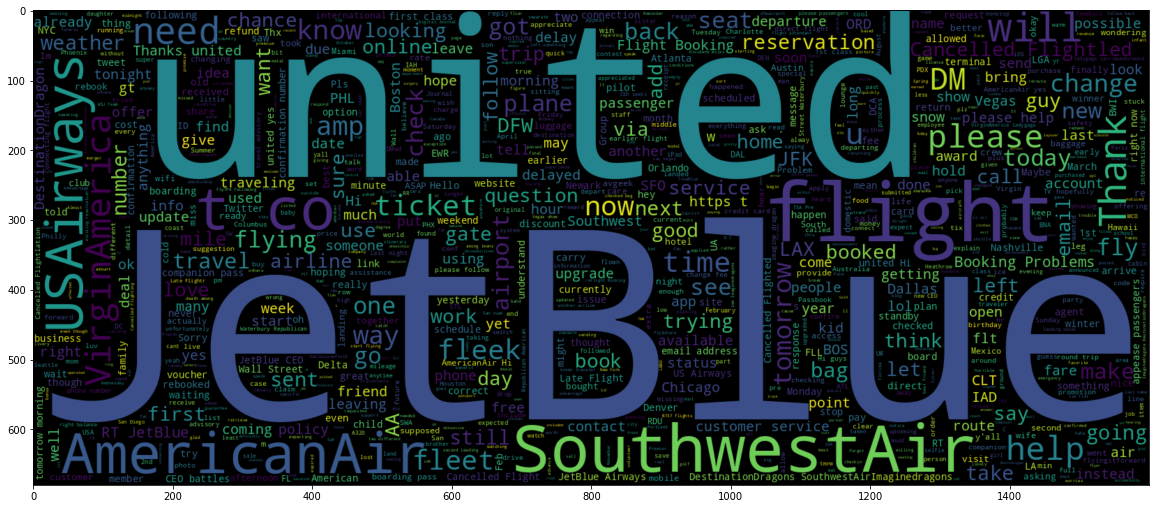

In [13]:
# word cloud of neutral sentiments
plt.figure(figsize = (20,20)) 
worldcould_neutral = WordCloud(min_font_size=3,  
                               max_words=1000,
                               width=1600,
                               height=680).generate(" ".join(neutral))

plt.imshow(worldcould_neutral,interpolation='bilinear')
ax.grid(False)

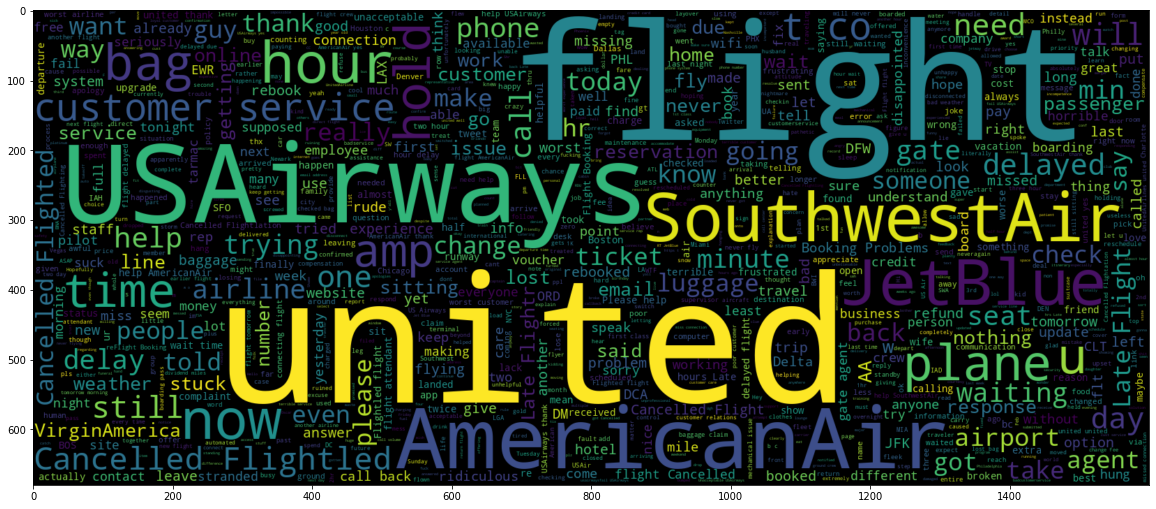

In [14]:
# word cloud of negative sentiments
plt.figure(figsize = (20,20)) 
worldcould_neg = WordCloud(min_font_size=3,
                           max_words=1000, 
                           width=1600, 
                           height=680).generate(" ".join(negative))

plt.imshow(worldcould_neg,interpolation = 'bilinear')
ax.grid(False)

## Data Cleaning

Tweets are inherently messy for ML models to interpret; emojis, punctuation, usernames all need to be removed and prior to being embedded and used for training. 

This section of the notebook tackles the data preparation and cleaning required to wrangle the dataset into a training-ready state. 

Firstly, we prepare the labels by converting the categories to integers. 

In [15]:
# convert Sentiments to 0,1,2
def convert_sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0
    
# Apply convert_sentiment function
df["airline_sentiment"] = df["airline_sentiment"].apply(lambda x : convert_sentiment(x))
df["airline_sentiment"]

0        1
1        2
2        1
3        0
4        0
        ..
14635    2
14636    0
14637    1
14638    0
14639    1
Name: airline_sentiment, Length: 14640, dtype: int64

Next we then perform a number of data cleaning and standardisation steps. This ensures that there are no quirky characters or usernames fed to our model later down the line which would cause issues. 

In [16]:
# Remove stop words
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    return text

# Remove url  
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Remove punct
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove html 
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove @username
def remove_username(text):
    return re.sub('@[^\s]+','',text)

# Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Decontraction text
def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text  

# Seperate alphanumeric
def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# Combine negative reason with tweet (if it exists)
df['final_text'] = df['negativereason'].fillna('') + ' ' + df['text'] 

# Apply functions to tweets
df['final_text'] = df['final_text'].apply(lambda x: remove_username(x))
df['final_text'] = df['final_text'].apply(lambda x: remove_url(x))
df['final_text'] = df['final_text'].apply(lambda x: remove_emoji(x))
df['final_text'] = df['final_text'].apply(lambda x: decontraction(x))
df['final_text'] = df['final_text'].apply(lambda x: seperate_alphanumeric(x))
df['final_text'] = df['final_text'].apply(lambda x: unique_char(cont_rep_char,x))
df['final_text'] = df['final_text'].apply(lambda x: char(x))
df['final_text'] = df['final_text'].apply(lambda x: x.lower())
df['final_text'] = df['final_text'].apply(lambda x: remove_stopwords(x))

# End result
df['final_text']

0                                                     said
1                  plus added commercials experience tacky
2                   today must mean need take another trip
3        bad flight really aggressive blast obnoxious e...
4                             ca tell really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    customer service issue leaving minutes late fl...
14637            please bring american airlines blackberry
14638    customer service issue money change flight ans...
14639    ppl need know many seats next flight plz put u...
Name: final_text, Length: 14640, dtype: object

Setting the X and y datasets ready for training. 

In [17]:
X = df['final_text']
y = df['airline_sentiment']

We then embed the tweets using the TF-IDF vectorizer. This is an industry standard embedding method and provides us with an array for each tweet which can then be used for training a range of ML algorithms. 

In [18]:
tfidf = TfidfVectorizer()
X_final =  tfidf.fit_transform(X)
X_final

<14640x10989 sparse matrix of type '<class 'numpy.float64'>'
	with 140653 stored elements in Compressed Sparse Row format>

Due to the imbalance in the dataset, with there being 3 times as many negatively sentimented tweets as any other category we use SMOTE to resample the minority classes. 

In [19]:
smote = SMOTE()
x_sm,y_sm = smote.fit_resample(X_final,y)

Finally, we split the data into training and testing sets. 

In [20]:
X_train , X_test , y_train , y_test = train_test_split(x_sm , y_sm , test_size=0.2)

## Model Training

Once the data has been prepared we are ready to train our ML model. 

In this case we will use a RandomForestClassifier from Scikit-Learn.

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [22]:
rf_prediction =  rf.predict(X_test)

In [23]:
accuracy_score(rf_prediction,y_test)

0.9567822771018704

Now that we have successfully generated our RandomForestClassifier we can generate a classification report, and visualise a confusion matrix to gain greater insights into our model's performance. 

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1819
           1       0.94      0.94      0.94      1826
           2       0.96      0.94      0.95      1862

    accuracy                           0.96      5507
   macro avg       0.96      0.96      0.96      5507
weighted avg       0.96      0.96      0.96      5507



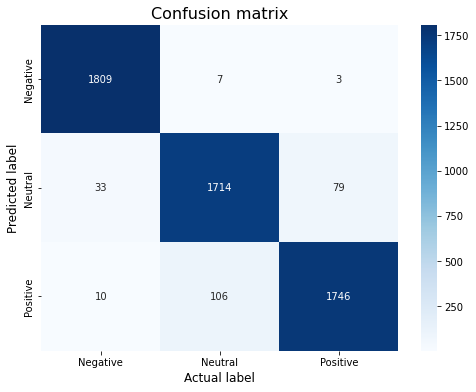

In [24]:
cr = classification_report(y_test, rf_prediction)

print("Classification Report:\n----------------------\n", cr)
cm = confusion_matrix(y_test,rf_prediction)

# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()

## Deploying the Model
As we have seen in the previous sections the tweets are pre-processed using a variety of techniques. In order to account for this we have 2 options for how to account for the pre-processing logic in production:
1. **Custom Model:** Incorporate the pre-processing directly in the `predict` method of a custom model. This provides simplicity when creating the deployment as there is only a single code base to worry about and a single component to be deployed.
2. **Input Transformer:** Make use of a separate container to perform all of the input transformation and then pass the vectors to the model for prediction. The schematic below outlines how this would work. 
```
            ________________________________________
            |            SeldonDeployment          |
            |                                      |
Request -->  Input transformer   -->     Model --> Response
            |  (Pre-processing)          (SKLearn) |
            |______________________________________|
```
The use of an input transformer allows us to separate the pre-processing logic from the prediction logic. This means we can leverage the pre-packaged SKLearn server provided by Seldon to serve our model, and each of the components can be upgraded independently of one another. However, it does introduce additional complexity in the deployment which is generated, and how that then interacts with advanced monitoring components such as outlier and drift detectors. 

This workshop will focus on the generation of a **custom model for this case**, therefore we need to define an `__init__` and `predict` method which shall load and perform inference respectively in our new deployment. 

---------

First we will save our model using joblib- SKLearn's recommended serialisation technology. 

In [25]:
joblib.dump(rf, 'model.joblib')

['model.joblib']

We also need to serialise our TF-IDF vectorizer in order to make use of it at runtime. This will ensure that we are using the same embeddings our model relyed upon at training time when inferring against new unseen data. 

In [26]:
joblib.dump(tfidf, 'tfidf.joblib')

['tfidf.joblib']

We can now copy the models over to GCS where they can be downloaded from later when we come to deploy. 

!!! Remember to replace your `<YOUR NAME>` with your name. !!!

In [28]:
!gsutil cp model.joblib gs://tom-seldon-examples/nlp-workshop/jman/model.joblib
!gsutil cp tfidf.joblib gs://tom-seldon-examples/nlp-workshop/jman/tfidf.joblib



Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

Copying file://model.joblib [Content-Type=application/octet-stream]...
| [1 files][ 72.1 MiB/ 72.1 MiB]    2.8 MiB/s                                   
Operation completed over 1 objects/72.1 MiB.                                     
Copying file://tfidf.joblib [Content-Type=application/octet-stream]...
/ [1 files][389.6 KiB/389.6 KiB]                                                
Operation completed over 1 objects/389.6 KiB.                                    


## Setup

We then define our Seldon custom model. The component parts required to build the custom model are outlined below. Each of the files play a key part in building the eventual Seldon docker container.

---
### TweetSentiment.py
This is the critical file as it contains the logic associated with the deployment wrapped as part of a class by the same name as the Python file. 

A key thing to note about the way this has been structured is that we have focused on making this deployment reusable. The `__init__` method accepts two custom predictor parameters; one for the saved model (`model_path`), and the other for the TF-IDF vectorizer (`tfidf_path`). 

The advantage of this is that it allows us to upgrade the model or vectorizer without having to re-build the container image. Additionally, if the logic was more general it could be used to accept a wider variety of objects for greater reusability. 

In [30]:
%%writefile TweetSentiment.py

from joblib import load
import logging
import pandas as pd
import numpy as np
import re
import seldon_core
import os

# For downloading the model and OHE encoder from GCS
from io import BytesIO
from google.cloud import storage

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords", download_dir="./nltk")
nltk.data.path.append("./nltk")

logger = logging.getLogger(__name__)


class TweetSentiment(object):

    def __init__(self, model_path, tfidf_path):
        logger.info(f"Connecting to GCS")
        self.client = storage.Client.create_anonymous_client()
        self.bucket = self.client.bucket('tom-seldon-examples')

        logger.info(f"Model name: {model_path}")
        self.model_path = model_path

        logger.info(f"TF-IDF Name: {tfidf_path}")
        self.tfidf_path = tfidf_path

        logger.info("Loading model file and TF-IDF vectorizer.")
        self.load_deployment_artefacts()
        self.ready = False

    def load_deployment_artefacts(self):
        logger.info("Loading model")
        model_file = BytesIO()
        model_blob = self.bucket.get_blob(f'{self.model_path}')
        model_blob.download_to_file(model_file)
        self.model = load(model_file)

        logger.info("Loading TF-IDF vectorizer")
        tfidf_file = BytesIO()
        tfidf_blob = self.bucket.get_blob(f'{self.tfidf_path}')
        tfidf_blob.download_to_file(tfidf_file)
        self.tfidf = load(tfidf_file)
        
        self.ready = True

    # Remove stop words
    def remove_stopwords(self, text):
        text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
        return text

    
    def char(self, text):
        substitute = re.sub(r'[^a-zA-Z]',' ',text)
        return substitute

    def predict(self, tweets, names=[], meta={}):
        try:
            if not self.ready:
                self.load_deployment_artefacts()
            else:
                final_text = []

                for text in tweets:
                    # Apply functions to tweets
                    text = self.remove_username(text)
                    text = self.remove_url(text)
                    text = self.remove_emoji(text)
                    text = self.decontraction(text)
                    text = self.seperate_alphanumeric(text)
                    text = self.unique_char(self.cont_rep_char,text)
                    text = self.char(text)
                    text = text.lower()
                    text = self.remove_stopwords(text)
                    final_text.append(text)

                logger.info(f"Final text to be embedded: {final_text}")
                embeddings = self.tfidf.transform(final_text)
                sentiment = self.model.predict(embeddings)
                return sentiment

        except Exception as ex:
            logging.exception(f"Failed during predict: {ex}")


Overwriting TweetSentiment.py


## Testing Locally
In order to ensure that we have gotten the `TweetClassifier.py` working correctly we can use the `seldon_core` Python package to run our model locally and test the endpoint. 
```
seldon-core-microservice TweetSentiment --service-type MODEL
                                        --parameters='[{ 
                                                        "name": "model_path",
                                                        "value": "nlp-workshop/<YOUR NAME>/model.joblib",
                                                        "type": "STRING"
                                                       }, {
                                                        "name": "tfidf_path",
                                                        "value": "nlp-workshop/<YOUR NAME>/tfidf.joblib",
                                                        "type": "STRING"
                                                       }]'
```
This endpoint can then be tested by posting cURL commands to the local endpoint: 
```
curl -H 'Content-Type: application/json' -d '{"data": {"ndarray": ["@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to someone about my bag. Status should matter."]}}' http://localhost:9000/api/v1.0/predictions
```

### .s2i/environment
In order for the Seldon base image to correctly convert your source code to an image it requires certain environment variables. In this case it is only 3 variables. 
* `MODEL_NAME`: The model name matches the name of the Python file and class which is created. 
* `SERVICE_TYPE`: Seldon allows you to create many different components each specialised for a different purpose e.g. `TRANSFORMER` for performing pre or post-processing steps. 
* `PERSISTENCE`: In some cases you would like to save the state of your deployments to Redis e.g. when scaling up multi-armed bandits

This is our environment file:
```
MODEL_NAME=TweetSentiment
SERVICE_TYPE=MODEL
PERSISTENCE=0
```
---
### requirements.txt
List of Python packages which the deployment requires to run.
```
joblib
pandas
numpy
seldon_core
google-cloud-storage
scikit-learn
nltk
```

## Building the Image

We can then build the custom model using source 2 image technology. Firstly, installing it locally as per [the documentation](https://github.com/openshift/source-to-image), and then by running this command: 
```
s2i build . seldonio/seldon-core-s2i-python3:1.12.0-dev tweet-sentiment:0.3
```

The built image is then pushed to Dockerhub where it can be pulled ready for deployment. In an enterprise setting, the container registry would be customised to the client's needs. 
```
docker tag tweet-sentiment:0.3 tomfarrand/tweet-sentiment:0.3
docker push tomfarrand/tweet-sentiment:0.3
```

In this case we will use my pre-built container image for speed and simplicity, which we can now deploy using the SDK. 

In [ ]:
!s2i build . seldonio/seldon-core-s2i-python3:1.12.0-dev tweet-sentiment:0.3

## Using the SDK
Now that we have our trained model artefact and preprocessor, alongside our custom built container we can now use the Seldon Deploy SDK to deploy our model! 

Initially we setup some authentication: 

In [ ]:
SD_IP = "34.125.69.167"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = 'client_credentials'

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

Next, we define the parameters which we shall feed to the SDK.

!!! Again, remember to fill in the `YOUR_NAME` parameter !!!

In [ ]:
YOUR_NAME = <YOUR NAME>
MODEL_NAME = "tweet-sentiment"

DEPLOYMENT_NAME = f"{YOUR_NAME}-{MODEL_NAME}"
CONTAINER_NAME = f"tomfarrand/tweet-sentiment:0.3"

NAMESPACE = "default"

CPU_REQUESTS = "0.1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "0.1"
MEMORY_LIMITS = "1Gi"

MODEL_PATH = f"nlp-workshop/{YOUR_NAME}/model.joblib"
TFIDF_PATH = f"nlp-workshop/{YOUR_NAME}/tfidf.joblib"

The deployment specification is then defined. 

In [ ]:
mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "image": CONTAINER_NAME,
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "parameters": [
                        {
                            "name":"model_path",
                            "value":MODEL_PATH,
                            "type":"STRING"
                        },
                        {
                            "name":"tfidf_path",
                            "value":TFIDF_PATH,
                            "type":"STRING"
                        }
                    ],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

Finally, we deploy the model using a few simple API calls. 

In [ ]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

Once our endpoint becomes available we can then test the deployment using the following request: 

```
{"data": {"ndarray": ["@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to someone about my bag. Status should matter."]}}
```